In [8]:
import nest_asyncio
nest_asyncio.apply()
import multiprocessing
# only set fork if not already set
if multiprocessing.get_start_method(allow_none=True) is None:
    multiprocessing.set_start_method("fork")
import pandas as pd
import stan
import numpy as np
from scipy.stats import pearsonr

from scipy.special import expit
import matplotlib.pyplot as plt
import arviz as az

## Matt Updates (8/25)
- Got conda environment that runs this notebook installed successfully 
- Now, to plug in real data 
- Anyway to suppress some of this output? 
- tried to add some upweighting to account for the fact that the 1000-image sample is not representative of overall image counts, not sure if this was the right intuition? The r_hat goes down to 1.0 for all of the fields, but there's this 'metropolis' error that pops up like 20 times. 
- i think something definitely needs to be done? these values aren't correct (which is what happens when i put 670/330 in, the raw counts of annotated neg/pos)

Working results that don't make sense 
- empirical_p_y 0.22638264951208253
- empirical_p_yhat 0.059639051600278256
- p_y_hat_1_given_y_1 0.21163348990040542
- p_y_hat_1_given_y_0 0.015385530450161835
- p_y_1_given_y_hat_1 0.8033352121400738
- p_y_1_given_y_hat_0 0.1897914834156601
- number of annotated classified negative which were positive: 132/670
- number of annotated classified positive which were positive: 276/330

In [9]:
# load actual reuslts 
ct_dataset = pd.read_csv("data/processed/flooding_ct_dataset.csv")
ct_dataset[['total_images','positive_images']] = ct_dataset[['total_images','positive_images']].astype(int).fillna(0)
print(ct_dataset.isna().sum())
ct_dataset.columns

CTLabel            0
BoroCode           0
BoroName           0
CT2020             0
BoroCT2020         0
CDEligibil         0
NTAName            0
NTA2020            0
CDTA2020           0
CDTANAME           0
GEOID              0
PUMA               0
Shape_Leng         0
Shape_Area         0
geometry           0
total_images       0
positive_images    0
dtype: int64


Index(['CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020', 'CDEligibil',
       'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID', 'PUMA',
       'Shape_Leng', 'Shape_Area', 'geometry', 'total_images',
       'positive_images'],
      dtype='object')

In [19]:
ct_dataset['positive_rate'] = ct_dataset['positive_images']/ct_dataset['total_images']
ct_dataset['positive_rate'] = ct_dataset['positive_rate'].fillna(0)
ct_dataset['positive_rate'].describe([0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

count    2325.000000
mean        0.001585
std         0.007370
min         0.000000
1%          0.000000
2.5%        0.000000
5%          0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
90%         0.003762
95%         0.007954
97.5%       0.013158
99%         0.025363
max         0.166667
Name: positive_rate, dtype: float64

# Emma notes (8/22):

In general, let's build complexity iteratively. Start by getting reasonable results without worrying about ICAR prior/smoothing. Then use standard ICAR prior (with weight 0.5). Then use full CAR (maybe). Data generation code is reviewed + model without proper CAR prior is reviewed. Another thing it might be nice to implement at some point is using the information about where the annotated images are (i.e., what Census tracts). Could incorporate this as a multinomial (potentially?) 

Model with simple L2 smoothing (or no smoothing at all - stan_code_with_weighted_ICAR_prior):

1. Consistently recovers parameters for realistic parameter settings (with no smoothing)
2. Reviewed Stan code and looks good. 
3. ALso implemented L2 regularization for adjacent Census tracts. This isn't actually the "proper" way to do it, but might be useful on real data. Haven't tested how this performs. 

Model wih full CAR prior (stan_code_proper_car_prior):

1. Haven't reviewed this or verified it recovers correct params (recently; I think I did a while ago). When you do review, don't need to re-review all the Bayesian conditioning math; it should be pretty similar to the old code. 


In [10]:
# Stan code with CAR prior seems to work but hasn't been reviewed. 
# CAR prior is https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html
stan_code_proper_car_prior = '''
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real tau, real alpha,
                       array[,] int W_sparse, vector D_sparse, vector lambda,
                       int n, int W_n) {
    row_vector[n] phit_D; // phi' * D
    row_vector[n] phit_W; // phi' * W
    vector[n] ldet_terms;
    
    phit_D = (phi .* D_sparse)';
    phit_W = rep_row_vector(0, n);
    for (i in 1 : W_n) {
      phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
      phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
    }
    
    for (i in 1 : n) {
      ldet_terms[i] = log1m(alpha * lambda[i]);
    }
    return 0.5
           * (n * log(tau) + sum(ldet_terms)
              - tau * (phit_D * phi - alpha * (phit_W * phi)));
  }
}

data {
  int<lower=0> N;
  int<lower=0> N_edges;
  matrix<lower=0, upper=1>[N, N] W; // adjacency matrix
  int W_n; // number of adjacent region pairs
  array[N] int<lower=0> n_images; 
  array[N] int<lower=0> n_classified_positive; 

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
transformed data {
  array[W_n, 2] int W_sparse; // adjacency pairs
  vector[N] D_sparse; // diagonal of D (number of neigbors for each site)
  vector[N] lambda; // eigenvalues of invsqrtD * W * invsqrtD
  
  {
    // generate sparse representation for W
    int counter;
    counter = 1;
    // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1 : (N - 1)) {
      for (j in (i + 1) : N) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1 : N) {
    D_sparse[i] = sum(W[i]);
  }
  {
    vector[N] invsqrtD;
    for (i in 1 : N) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}

parameters {
  vector[N] phi;
  real<lower=0> tau;
  real<lower=0, upper=1> alpha;
  real <upper=0>phi_offset; // you may not want to place this constraint but it helps convergence with small numbers of samples
  real<lower=0, upper=1> p_y_1_given_y_hat_1; 
  real<lower=0, upper=1> p_y_1_given_y_hat_0;
}
transformed parameters {
    vector[N] p_y = inv_logit(phi + phi_offset);
    //real predicted_overall_p_y = sum(n_images .* p_y) / sum(n_images);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative , p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  tau ~ gamma(2, 2);
  phi ~ sparse_car(tau, alpha, W_sparse, D_sparse, lambda, N, W_n);
  phi_offset ~ normal(-4, 0.5);
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''

# Stan code below works and has been reviewed but does not implement a proper ICAR prior. Set variable use_ICAR_prior to 0 if you don't want to use one at all. 
# I think it might also be principled to set the ICAR prior weight to 0.5, https://mc-stan.org/users/documentation/case-studies/icar_stan.html. 
stan_code_with_weighted_ICAR_prior = '''
data {
  int<lower=0> N; // number of Census tracts. 
  int<lower=0> N_edges; // number of edges in the graph (i.e. number of pairs of adjacent Census tracts). 
  array[N_edges] int<lower=1, upper=N> node1; // node1[i] adjacent to node2[i]
  array[N_edges] int<lower=1, upper=N> node2; // and node1[i] < node2[i]
  array[N] int<lower=0> n_images; // vector with one entry per Census tract of the number of images in that tract. 
  array[N] int<lower=0> n_classified_positive; // vector with one entry per Census tract of number of images classified positive. 
  int<lower=0,upper=1> use_ICAR_prior; // 1 if you want to use ICAR prior, 0 if you don't. ICAR prior basically smooths the data. 
  real <lower=0> ICAR_prior_weight; // weight of ICAR prior.

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
parameters {
  vector[N] phi;
  real<upper=0> phi_offset; // this is the mean from which phis are drawn. Upper bound at 0 to rule out bad modes and set prior that true positives are rare. 
  ordered[2] logit_p_y_1_given_y_hat; // ordered to impose the constraint that p_y_1_given_y_hat_0 < p_y_1_given_y_hat_1.
}
transformed parameters {
    real p_y_1_given_y_hat_0 = inv_logit(logit_p_y_1_given_y_hat[1]);
    real p_y_1_given_y_hat_1 = inv_logit(logit_p_y_1_given_y_hat[2]);
    vector[N] p_y = inv_logit(phi);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {
  // You can't just scale ICAR priors by random numbers; the only principled value for ICAR_prior_weight is 0.5. 
  // https://stats.stackexchange.com/questions/333258/strength-parameter-in-icar-spatial-model
  // still, there's no computational reason you can't use another value. 
  if (use_ICAR_prior == 1) {
    target += -ICAR_prior_weight * dot_self(phi[node1] - phi[node2]);
  }

  // model the results on the annotation set. 
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  
  // model the results by Census tract. 
  phi_offset ~ normal(0, 2);
  phi ~ normal(phi_offset, 1); 
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''

In [11]:
import numpy as np
import random
from scipy.special import expit

def generate_real_data(df, 
                       n_annotated_classified_negative, 
                       n_annotated_classified_positive, 
                       icar_prior_setting, 
                       scaling_factor_positive=1.0, 
                       scaling_factor_negative=1.0):
    """
    Generate data for the model using real data from a DataFrame, with scaling factors to modulate the influence 
    of annotated data.
    """
    # HERE: changed this from 1000 
    N = len(df)
    total_images = df['total_images'].values
    positive_images = df['positive_images'].values

    # Generate adjacency matrix and neighborhood structure
    node1 = []
    node2 = []
    for i in range(N):
        for j in range(i + 1, N):
            if np.random.rand() < 0.1:
                node1.append(i + 1)  # one indexing for Stan
                node2.append(j + 1)

    # ONLY PLUG IN OBSERVED DATA from the ct_dataset here
    # WRITE UP 'how do i install stan' walkthrough in onboarding on G2 
    

    return {'observed_data': {
                'N': N, 'N_edges': len(node1), 'node1': node1, 'node2': node2, 
                'n_images': df['total_images'].tolist(),
                'n_classified_positive': df['positive_images'].tolist(), 
                'n_annotated_classified_negative': 500,
                'n_annotated_classified_positive': 500,
                'n_annotated_classified_negative_true_positive': 3,
                'n_annotated_classified_positive_true_positive': 330
            }
           }

In [12]:
import random
def generate_simulated_data(N, images_per_location, 
                            n_annotated_classified_negative, 
                            n_annotated_classified_positive, 
                            icar_prior_setting):
    """
    Generate simulated data for the model.
    """    
    node1 = []
    node2 = []
    for i in range(N):
        for j in range(i+1, N):
            if np.random.rand() < 0.1:
                node1.append(i + 1) # one indexing for Stan. 
                node2.append(j + 1)
    phi_offset = random.random() * -3 - 1 # mean of phi.

    # these only matter for CAR model. https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html
    D = np.zeros((N, N))
    W = np.zeros((N, N))
    for i in range(len(node1)):
        D[node1[i] - 1, node1[i] - 1] += 1
        D[node2[i] - 1, node2[i] - 1] += 1
        W[node1[i] - 1, node2[i] - 1] = 1
        W[node2[i] - 1, node1[i] - 1] = 1
    B = np.linalg.inv(D) @ W
    tau = np.random.gamma(scale=0.2, shape=2)
    alpha = np.random.random()
    sigma = np.linalg.inv(tau * D @ (np.eye(N) - alpha * B))
    if icar_prior_setting != 'none':    
        phi = np.random.multivariate_normal(mean=np.zeros(N), cov=sigma)
    else:
        phi = np.random.normal(loc=0, size=N) # this uses no icar prior, just draws everything independently. 
    p_Y = expit(phi + phi_offset)
    n_images = np.random.poisson(images_per_location, N)
    p_y_hat_1_given_y_1 = random.random() * 0.5 + 0.2
    p_y_hat_1_given_y_0 = random.random() * 0.01 + 0.01

    n_classified_positive = []
    n_true_positive = []
    for i in range(N):
        n_true_positive.append(np.random.binomial(n_images[i], p_Y[i]))
        n_classified_positive.append(np.random.binomial(n_true_positive[-1], p_y_hat_1_given_y_1) + 
                                    np.random.binomial(n_images[i] - n_true_positive[-1], p_y_hat_1_given_y_0))
    empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images)
    empirical_p_y = sum(n_true_positive) * 1.0 / sum(n_images)
    p_y_1_given_y_hat_1 = p_y_hat_1_given_y_1 * empirical_p_y / empirical_p_yhat
    p_y_1_given_y_hat_0 = (1 - p_y_hat_1_given_y_1) * empirical_p_y / (1 - empirical_p_yhat)
    print("empirical_p_y", empirical_p_y)
    print("empirical_p_yhat", empirical_p_yhat)
    print("p_y_hat_1_given_y_1", p_y_hat_1_given_y_1)
    print("p_y_hat_1_given_y_0", p_y_hat_1_given_y_0)
    print("p_y_1_given_y_hat_1", p_y_1_given_y_hat_1)
    print("p_y_1_given_y_hat_0", p_y_1_given_y_hat_0)
                     
    n_annotated_classified_negative_true_positive = np.random.binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0)
    n_annotated_classified_positive_true_positive = np.random.binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1)
    print("number of annotated classified negative which were positive: %i/%i" % (n_annotated_classified_negative_true_positive, n_annotated_classified_negative))
    print("number of annotated classified positive which were positive: %i/%i" % (n_annotated_classified_positive_true_positive, n_annotated_classified_positive))
    

    return {'observed_data':{'N':N, 'N_edges':len(node1), 'node1':node1, 'node2':node2, 
                             'n_images':n_images, 'n_classified_positive':n_classified_positive, 
                             'n_annotated_classified_negative':n_annotated_classified_negative,
                                'n_annotated_classified_positive':n_annotated_classified_positive,
                                'n_annotated_classified_negative_true_positive':n_annotated_classified_negative_true_positive,
                                'n_annotated_classified_positive_true_positive':n_annotated_classified_positive_true_positive},

            'parameters':{'phi':phi, 'phi_offset':phi_offset, 
                          'p_y_1_given_y_hat_1':p_y_1_given_y_hat_1,
                            'p_y_1_given_y_hat_0':p_y_1_given_y_hat_0, 
                            'p_y_hat_1_given_y_1':p_y_hat_1_given_y_1,
                            'p_y_hat_1_given_y_0':p_y_hat_1_given_y_0, 
                            'p_Y':p_Y, 
                            'tau':tau, 'alpha':alpha, 'sigma':sigma}}

In [13]:
icar_prior_setting = 'none'
assert icar_prior_setting in ['none', 'cheating', 'proper']

# Annotated counts
NUM_CLASSIFIED_POSITIVE_ANNOTATED_POSITIVE = 329
NUM_CLASSIFIED_POSITIVE_ANNOTATED_NEGATIVE = 171 
NUM_CLASSIFIED_NEGATIVE_ANNOTATED_POSITIVE = 3 
NUM_CLASSIFIED_NEGATIVE_ANNOTATED_NEGATIVE = 497


# Total counts in the dataset
TOTAL_PRED_POSITIVE = 1465 
TOTAL_PRED_NEGATIVE = 924747


for i in range(1):
    NUM_WARMUP = 2000
    NUM_SAMPLES = 8000
    N = NUM_SAMPLES
    
    # Use the scaled counts in the model
    data = generate_real_data(ct_dataset,
                                n_annotated_classified_negative=670,
                                n_annotated_classified_positive=330,
                                icar_prior_setting=icar_prior_setting)
                                
    
    if icar_prior_setting == 'proper':
        raise Exception("Haven't verified that this model actually works! Need to review it / check on simulated data.")
        W = np.zeros((N, N))
        
        for i in range(len(data['observed_data']['node1'])):
            W[data['observed_data']['node1'][i] - 1, 
                                data['observed_data']['node2'][i] - 1] = 1
            W[data['observed_data']['node2'][i] - 1, 
                                data['observed_data']['node1'][i] - 1] = 1
        del data['observed_data']['node1']
        del data['observed_data']['node2']
        data['observed_data']['W'] = W
        data['observed_data']['W_n'] = int(W.sum() / 2)
        model = stan.build(stan_code_proper_car_prior, data=data['observed_data'])
    elif icar_prior_setting == 'cheating':
        data['observed_data']['use_ICAR_prior'] = 1
        data['observed_data']['ICAR_prior_weight'] = 0.05
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=data['observed_data'])
    elif icar_prior_setting == 'none':
        data['observed_data']['use_ICAR_prior'] = 0
        data['observed_data']['ICAR_prior_weight'] = 0
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=data['observed_data'])
    else:
        raise ValueError("Invalid icar_prior_options", icar_prior_setting)
    
    fit = model.sample(num_chains=4, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
    print(az.summary(fit, var_names=['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 'phi_offset', 
                                    'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                    'empirical_p_yhat']))

    df = fit.to_frame()

    inferred_p_y = [df[f'p_y.{i}'].mean() for i in range(1, len(ct_dataset) + 1)]
    # changing this to compute p_y from observed data 
    #p_y = np.nan_to_num(np.array(data['observed_data']['n_classified_positive']) / np.array(data['observed_data']['n_images']),0)
    #plt.scatter(p_y, inferred_p_y)
    #plt.title("True vs. inferred p_Y, r = %.2f" %
            #pearsonr(p_y, inferred_p_y)[0])
    #max_val = max(max(p_y), max(inferred_p_y))
    #plt.xlabel("True p_Y")
    #plt.ylabel("Inferred p_Y")
    #plt.plot([0, max_val], [0, max_val], 'r--')
    #plt.xlim([0, max_val])
    #plt.ylim([0, max_val])
    #plt.figure(figsize=[12, 3])
    
    if icar_prior_setting == 'proper':
        param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset', 'alpha', 'tau']
    else:
        param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset']
    
    #for k in param_names:
    #    plt.subplot(1, len(param_names), param_names.index(k) + 1)
    #    plt.hist(df[k], bins=50, density=True)
    #    plt.title(k)
    #    plt.axvline(data['parameters'][k], color='red')
    
    #plt.show()

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/40000)
Sampling:   0% (2/40000)
Sampling:   0% (3/40000)
Sampling:   0% (4/40000)
Sampling:   0% (103/40000)
Sampling:   1% (203/40000)
Sampling:   1% (303/40000)
Sampling:   1% (403/40000)
Sampling:   1% (503/40000)
Sampling:   2% (602/40000)
Sampling:   2% (702/40000)
Sampling:   2% (802/40000)
Sampling:   2% (902/40000)
Sampling:   3% (1002/40000)
Sampling:   3% (1102/40000)
Sampling:   3% (1202/40000)
Sampling:   3% (1301/40000)
Sampling:   4% (1401/40000)
Sampling:   4% (1501/40000)
Sampling:   4% (1601/40000)
Sampling:   4% (1700/40000)
Sampling:   4% (1800/40000)
Sampling:   5% (1900/40000)
Sampling:   5% (2000/40000)
Sampling:   5% (2100/40000)
Sampling:   6% (2200/40000)
Sampling:   6% (2300/40000)
Sampling:   6% (2400/40000)
Sampling:   6% (2500/40000)
Sampling:   6% (2600/40000)
Sampling:   7% (2700/40000)
Sampling:   7% (2800/40000)
Sampling:   7% (2900/40000)
Sampling:   8% (3000/40000)
S

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.452  0.127   0.236    0.692      0.010    0.007   
p_y_hat_1_given_y_0  0.000  0.000   0.000    0.000      0.000    0.000   
phi_offset          -6.584  0.288  -7.121   -6.058      0.024    0.017   
p_y_1_given_y_hat_1  0.779  0.015   0.750    0.806      0.000    0.000   
p_y_1_given_y_hat_0  0.002  0.001   0.000    0.003      0.000    0.000   
empirical_p_yhat     0.002  0.000   0.002    0.002      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1     151.0     476.0   1.02  
p_y_hat_1_given_y_0   28781.0   26752.0   1.00  
phi_offset              148.0     466.0   1.02  
p_y_1_given_y_hat_1   28444.0   26648.0   1.00  
p_y_1_given_y_hat_0     151.0     480.0   1.02  
empirical_p_yhat      32000.0   32000.0    NaN  


Text(0.5, 1.0, 'Inferred p_Y')

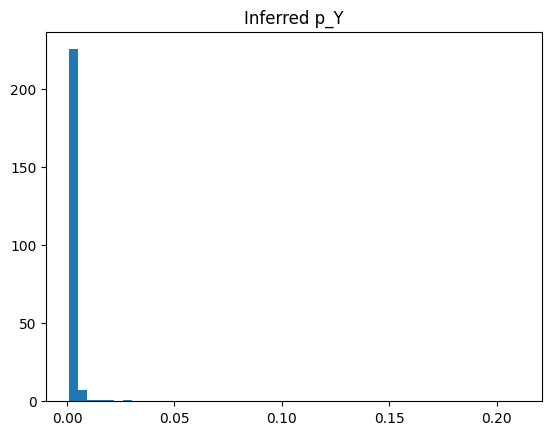

In [16]:
# histogram of inferred p_y 
fig, ax = plt.subplots()
ax.hist(inferred_p_y, bins=50, density=True)
ax.set_title("Inferred p_Y")


In [18]:
pd.Series(inferred_p_y).describe([0.01, 0.025, 0.05, 0.125, 0.25, 0.5, 0.75, 0.875, 0.95, 0.975, 0.99])

count    2325.000000
mean        0.002912
std         0.007684
min         0.000783
1%          0.001028
2.5%        0.001148
5%          0.001298
12.5%       0.001519
25%         0.001727
50%         0.001943
75%         0.002150
87.5%       0.003029
95%         0.005168
97.5%       0.008859
99%         0.023081
max         0.210722
dtype: float64

In [ ]:
icar_prior_setting = 'none'
assert icar_prior_setting in ['none', 'cheating', 'proper']
for i in range(10):
    NUM_WARMUP = 2000
    NUM_SAMPLES = 1000
    N = 1000
    simulated_data = generate_simulated_data(N=N, 
                                                images_per_location=1000, 
                                                n_annotated_classified_negative=500, 
                                                n_annotated_classified_positive=500, 
                                                icar_prior_setting=icar_prior_setting)
    if icar_prior_setting == 'proper':
        raise Exception("Haven't verified that this model actually works! Need to review it / check on simulated data. No need to review the parts which are identical to the other model.")
        W = np.zeros((N, N))
        
        for i in range(len(simulated_data['observed_data']['node1'])):
            W[simulated_data['observed_data']['node1'][i] - 1, 
                                simulated_data['observed_data']['node2'][i] - 1] = 1
            W[simulated_data['observed_data']['node2'][i] - 1, 
                                simulated_data['observed_data']['node1'][i] - 1] = 1
        del simulated_data['observed_data']['node1']
        del simulated_data['observed_data']['node2']
        simulated_data['observed_data']['W'] = W
        simulated_data['observed_data']['W_n'] = int(W.sum() / 2)
        model = stan.build(stan_code_proper_car_prior, data=simulated_data['observed_data'])
    elif icar_prior_setting == 'cheating':
        simulated_data['observed_data']['use_ICAR_prior'] = 1
        simulated_data['observed_data']['ICAR_prior_weight'] = 0.05
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=simulated_data['observed_data'])
    elif icar_prior_setting == 'none':
        simulated_data['observed_data']['use_ICAR_prior'] = 0
        simulated_data['observed_data']['ICAR_prior_weight'] = 0
        model = stan.build(stan_code_with_weighted_ICAR_prior, data=simulated_data['observed_data'])
    else:
        raise ValueError("Invalid icar_prior_options", icar_prior_setting)
    fit = model.sample(num_chains=4, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
    print(az.summary(fit, var_names=['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 'phi_offset', 
                                    'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                    'empirical_p_yhat']))

    df = fit.to_frame()

    inferred_p_y = [df[f'p_y.{i}'].mean() for i in range(1, N + 1)]
    plt.scatter(simulated_data['parameters']['p_Y'], inferred_p_y)
    plt.title("True vs. inferred p_Y, r = %.2f" %
            pearsonr(simulated_data['parameters']['p_Y'], inferred_p_y)[0])
    max_val = max(max(simulated_data['parameters']['p_Y']), max(inferred_p_y))
    plt.xlabel("True p_Y")
    plt.ylabel("Inferred p_Y")
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlim([0, max_val])
    plt.ylim([0, max_val])
    plt.figure(figsize=[12, 3])
    if icar_prior_setting == 'proper':
        param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset', 'alpha', 'tau']
    else:
        param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset']
    for k in param_names:
        plt.subplot(1, len(param_names), param_names.index(k) + 1)
        # histogram of posterior samples
        plt.hist(df[k], bins=50, density=True)
        plt.title(k)
        plt.axvline(simulated_data['parameters'][k], color='red')
    plt.show()
    #az.plot_trace(fit, var_names=['sigma_Z'])


# Code below here is deprecated. 

In [ ]:
# Stan code below "works" but cheats on the ICAR prior. Set variable use_ICAR_prior to 0 if you don't want to use one at all.  
DEPRECATED_stan_code_cheating_ICAR_prior_with_soft_zero_constraint = '''
data {
  int<lower=0> N;
  int<lower=0> N_edges;
  array[N_edges] int<lower=1, upper=N> node1; // node1[i] adjacent to node2[i]
  array[N_edges] int<lower=1, upper=N> node2; // and node1[i] < node2[i]
  array[N] int<lower=0> n_images; 
  array[N] int<lower=0> n_classified_positive; 
  int<lower=0,upper=1> use_ICAR_prior; // 1 if you want to use ICAR prior, 0 if you don't. ICAR prior basically smooths the data. 
  real <lower=0> ICAR_prior_weight; // weight of ICAR prior.

  //annotation sample. 
  int n_annotated_classified_negative;
  int n_annotated_classified_positive;
  int n_annotated_classified_negative_true_positive;
  int n_annotated_classified_positive_true_positive;  
}
parameters {
  vector[N] phi;
  real phi_offset; 
  real<lower=0, upper=1> p_y_1_given_y_hat_1; 
  real<lower=0, upper=1> p_y_1_given_y_hat_0;
}
transformed parameters {
    vector[N] p_y = inv_logit(phi + phi_offset);
    //real predicted_overall_p_y = sum(n_images .* p_y) / sum(n_images);
    real empirical_p_yhat = sum(n_classified_positive) * 1.0 / sum(n_images);
    real p_y_hat_1_given_y_1 = empirical_p_yhat * p_y_1_given_y_hat_1 / (empirical_p_yhat * p_y_1_given_y_hat_1 + (1 - empirical_p_yhat) * p_y_1_given_y_hat_0);
    real p_y_hat_1_given_y_0 = empirical_p_yhat * (1 - p_y_1_given_y_hat_1) / (empirical_p_yhat * (1 - p_y_1_given_y_hat_1) + (1 - empirical_p_yhat) * (1 - p_y_1_given_y_hat_0));
}
model {

  // You can't just scale ICAR priors by random numbers, so this is "cheating". Still, maybe a good sanity check. 
  // https://stats.stackexchange.com/questions/333258/strength-parameter-in-icar-spatial-model
  if (use_ICAR_prior == 1) {
    target += -ICAR_prior_weight * dot_self(phi[node1] - phi[node2]);
  }
  n_annotated_classified_negative_true_positive ~ binomial(n_annotated_classified_negative, p_y_1_given_y_hat_0);
  n_annotated_classified_positive_true_positive ~ binomial(n_annotated_classified_positive, p_y_1_given_y_hat_1);
  
  // soft sum-to-zero constraint on phi,
  // equivalent to mean(phi) ~ normal(0,0.01)
  phi_offset ~ normal(0, 2);
  //sum(phi) ~ normal(0, 0.01 * N); // ZERO CENTERED.
  n_classified_positive ~ binomial(n_images, p_y .* p_y_hat_1_given_y_1 + (1 - p_y) .* p_y_hat_1_given_y_0);
}
'''
